
Active Power Loss Data
1: 0.0002
2: 0.0006
3: 0.0002
4: 0.0002
5: 0.0006
6: 0.0001
7: 0.0002
8: 0.0001
9: 0.0001
10: 0.0000
11: 0.0000
12: 0.0000
13: 0.0000
14: 0.0000
15: 0.0000
16: 0.0000
17: 0.0000
18: 0.0000
19: 0.0000
20: 0.0000
21: 0.0000
22: 0.0000
23: 0.0001
24: 0.0000
25: 0.0000
26: 0.0000
27: 0.0001
28: 0.0001
29: 0.0000
30: 0.0000
31: 0.0000
32: 0.0000

Reactive Power Loss Data
1:-0.0001
2:-0.0005
3:-0.0002
4:-0.0002
5:-0.0004
6:0.0000
7:-0.0001
8:-0.0000
9:-0.0000
10:-0.0000
11:-0.0000
12:-0.0000
13:0.0000
14:0.0000
15:-0.0000
16:0.0000
17:-0.0000
18:-0.0000
19:-0.0000
20:0.0000
21:0.0000
22:-0.0000
23:-0.0000
24:-0.0000
25:-0.0000
26:-0.0000
27:-0.0002
28:-0.0001
29:-0.0001
30:-0.0000
31:-0.0000
32:-0.0000

Voltage Magnitude at Each Bus (pu):
Bus1: 1.0000
Bus2: 0.9960
Bus3: 0.9768
Bus4: 0.9665
Bus5: 0.9564
Bus6: 0.9311
Bus7: 0.9263
Bus8: 0.9076
Bus9: 0.8989
Bus10: 0.8908
Bus11: 0.8896
Bus12: 0.8875
Bus13: 0.8790
Bus14: 0.8759
Bus15: 0.8739
Bus16: 0.8720
Bus17: 0.8692
Bus1

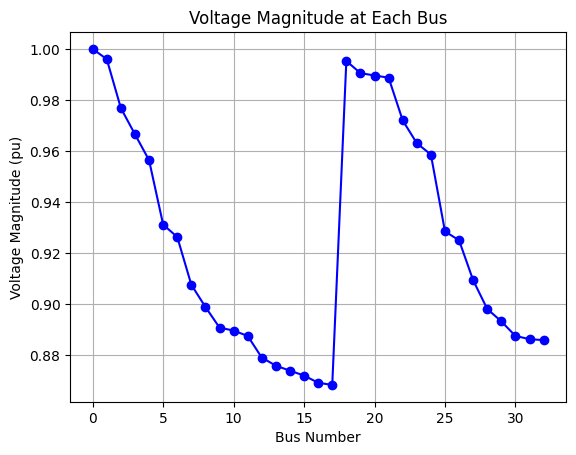

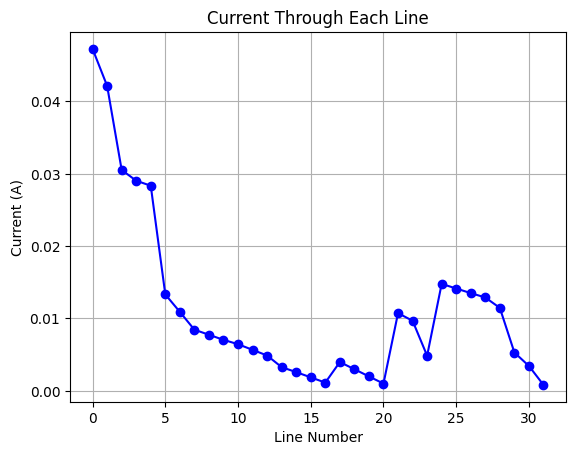

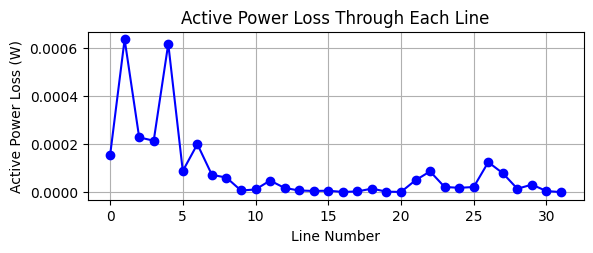

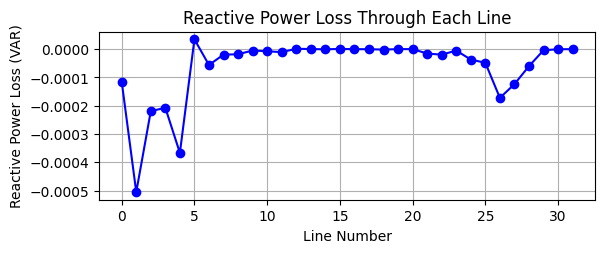

Total Active Power Loss: 0.0028 W
Total Reactive Power Loss: -0.0020 VAR
Total Power Loss: 0.0009 VA


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
from openpyxl.styles import Alignment

LD = np.loadtxt('linedata33bus.m')
BD = np.loadtxt('busdata33bus.m')

Sbase = 100  # MVA
Vbase = 11   # kV
Zbase = (Vbase**2) / Sbase

LD[:, 3:5] /= Zbase
BD[:, 1:3] /= (1000 * Sbase)

N = int(np.max(np.max(LD[:, 1:3])))

Sload = BD[:, 1] + 1j * BD[:, 2]

V = np.ones_like(BD[:, 0], dtype=np.complex128)

Z = LD[:, 3] + 1j * LD[:, 4]

Iline = np.zeros_like(LD[:, 0], dtype=np.complex128)

Iter = 2000

# The Algorithm
for _ in range(Iter):
    
    # Backward Sweep
    Iload = np.conj(Sload / V)

    for j in range(len(LD) - 1, -1, -1):
       c = np.where(LD[:, 1:3] == LD[j, 2])[0]
       if len(c) == 1:
        Iline[int(LD[j, 0]) - 1] = Iload[int(LD[j, 2]) - 1]
       else:
        Iline[int(LD[j, 0]) - 1] = Iload[int(LD[j, 2]) - 1] + np.sum(Iline[c.astype(int)]) - Iline[int(LD[j, 0]) - 1]

    # Forward Sweep
    for j in range(len(LD)):
        V[int(LD[j, 2]) - 1] = V[int(LD[j, 1]) - 1] - Iline[int(LD[j, 0]) - 1] * Z[j]

Voltage = np.abs(V)
Vangle = np.angle(V)


# Calculate current through each line
Iline_magnitude = np.abs(Iline)

# Calculate power losses for each line
P_loss = np.real(Z * (Iline**2))
Q_loss = np.imag(Z * (Iline**2))
total_loss = np.sum(P_loss) + np.sum(Q_loss)



print("\nActive Power Loss Data")
for i in range(len(P_loss)):
    print(f'{i + 1}: {P_loss[i]:.4f}')

print("\nReactive Power Loss Data")
for i in range(len(Q_loss)):
    print(f'{i + 1}:{Q_loss[i]:.4f}')

print("\nVoltage Magnitude at Each Bus (pu):")
for i in range(len(Voltage)):
    print(f'Bus{i + 1}: {Voltage[i]:.4f}')


print("\nCurrent Through Each Line:")
for i in range(len(Iline_magnitude)):
    print(f'Line{i + 1}: {Iline_magnitude[i]:.4f} A')
    

# Plot voltage
plt.figure()
plt.plot(Voltage, 'bo-')
plt.xlabel('Bus Number')
plt.ylabel('Voltage Magnitude (pu)')
plt.title('Voltage Magnitude at Each Bus')
plt.grid(True)
plt.show()

print("\n")
# Plotting current through each line
plt.figure()
plt.plot(Iline_magnitude, 'bo-')
plt.xlabel('Line Number')
plt.ylabel('Current (A)')
plt.title('Current Through Each Line')
plt.grid(True)
plt.show()

print("\n")
# Plotting power losses for each line
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(P_loss, 'bo-')
plt.xlabel('Line Number')
plt.ylabel('Active Power Loss (W)')
plt.title('Active Power Loss Through Each Line')
plt.grid(True)
plt.show()

# Plotting Reactive Power Loss Through Each Line
plt.subplot(2, 1, 2)
plt.plot(Q_loss, 'bo-')
plt.xlabel('Line Number')
plt.ylabel('Reactive Power Loss (VAR)')
plt.title('Reactive Power Loss Through Each Line')
plt.grid(True)
plt.show()

# Display total power loss
print(f'Total Active Power Loss: {np.sum(P_loss):.4f} W')
print(f'Total Reactive Power Loss: {np.sum(Q_loss):.4f} VAR')
print(f'Total Power Loss: {total_loss:.4f} VA')


excel_filename = 'test_data.xlsx'

workbook = openpyxl.Workbook()
worksheet = workbook.active

# Sheet 1
worksheet.append(['Index', 'Power Loss'])
worksheet.title = "Power Loss"

# Write data rows in the loop
for i in range(len(P_loss)):
    index_cell = worksheet.cell(row=i + 2, column=1)
    power_loss_cell = worksheet.cell(row=i + 2, column=2)
    
    # Set left alignment for both cells
    index_cell.alignment = Alignment(horizontal='right')
    power_loss_cell.alignment = Alignment(horizontal='right')
    
    # Write data to the cells
    index_cell.value = i + 1
    power_loss_cell.value = f'{P_loss[i]:.4f}'

# for i in range(len(P_loss)):
#     worksheet.append([i + 1, f'{P_loss[i]:.4f}'])
     
# Sheet 2
worksheet2 = workbook.create_sheet("Reactive Power Loss")
worksheet2.append(['Index', 'Reactive Power Loss'])

for i in range(len(Q_loss)):
    index_cell = worksheet2.cell(row=i + 2, column=1)
    rpower_loss_cell = worksheet2.cell(row=i + 2, column=2)
    
    # Set left alignment for both cells
    index_cell.alignment = Alignment(horizontal='right')
    rpower_loss_cell.alignment = Alignment(horizontal='right')
    
    # Write data to the cells
    index_cell.value = i + 1
    rpower_loss_cell.value = f'{Q_loss[i]:.4f}'


# for i in range(len(Q_loss)):
#     worksheet2.append([i + 1, f'{Q_loss[i]:.4f}'])

# Sheet 3
worksheet3 = workbook.create_sheet("Voltage Magnitude at Each Bus")
worksheet3.append(['Bus No', 'Voltage Magnitude at Each Bus'])

for i in range(len(Voltage)):
    index_cell = worksheet3.cell(row=i + 2, column=1)
    voltage_cell = worksheet3.cell(row=i + 2, column=2)
    
    # Set left alignment for both cells
    index_cell.alignment = Alignment(horizontal='right')
    voltage_cell.alignment = Alignment(horizontal='right')
    
    # Write data to the cells
    index_cell.value = i + 1
    voltage_cell.value = f'{Voltage[i]:.4f}'


# for i in range(len(Voltage)):
#     worksheet3.append([i + 1, f'{Voltage[i]:.4f}'])
    
# Sheet 4
worksheet4 = workbook.create_sheet("Current Through Each Line")
worksheet4.append(['Line No', 'Current Through Each Line'])

for i in range(len(Iline_magnitude)):
    index_cell = worksheet4.cell(row=i + 2, column=1)
    magnitude_cell = worksheet4.cell(row=i + 2, column=2)
    
    # Set left alignment for both cells
    index_cell.alignment = Alignment(horizontal='right')
    magnitude_cell.alignment = Alignment(horizontal='right')
    
    # Write data to the cells
    index_cell.value = i + 1
    magnitude_cell.value = f'{Iline_magnitude[i]:.4f}'

# for i in range(len(Iline_magnitude)):
#     worksheet4.append([i + 1, f'{Iline_magnitude[i]:.4f}'])
   
# Save the workbook
workbook.save(excel_filename)

